In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df=pd.read_csv('energy_efficiency_data.csv')
df.head()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Relative_Compactness       768 non-null    float64
 1   Surface_Area               768 non-null    float64
 2   Wall_Area                  768 non-null    float64
 3   Roof_Area                  768 non-null    float64
 4   Overall_Height             768 non-null    float64
 5   Orientation                768 non-null    int64  
 6   Glazing_Area               768 non-null    float64
 7   Glazing_Area_Distribution  768 non-null    int64  
 8   Heating_Load               768 non-null    float64
 9   Cooling_Load               768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


In [4]:
df.columns

Index(['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area',
       'Overall_Height', 'Orientation', 'Glazing_Area',
       'Glazing_Area_Distribution', 'Heating_Load', 'Cooling_Load'],
      dtype='object')

In [5]:
df.isnull().sum()

Relative_Compactness         0
Surface_Area                 0
Wall_Area                    0
Roof_Area                    0
Overall_Height               0
Orientation                  0
Glazing_Area                 0
Glazing_Area_Distribution    0
Heating_Load                 0
Cooling_Load                 0
dtype: int64

# Visualization 

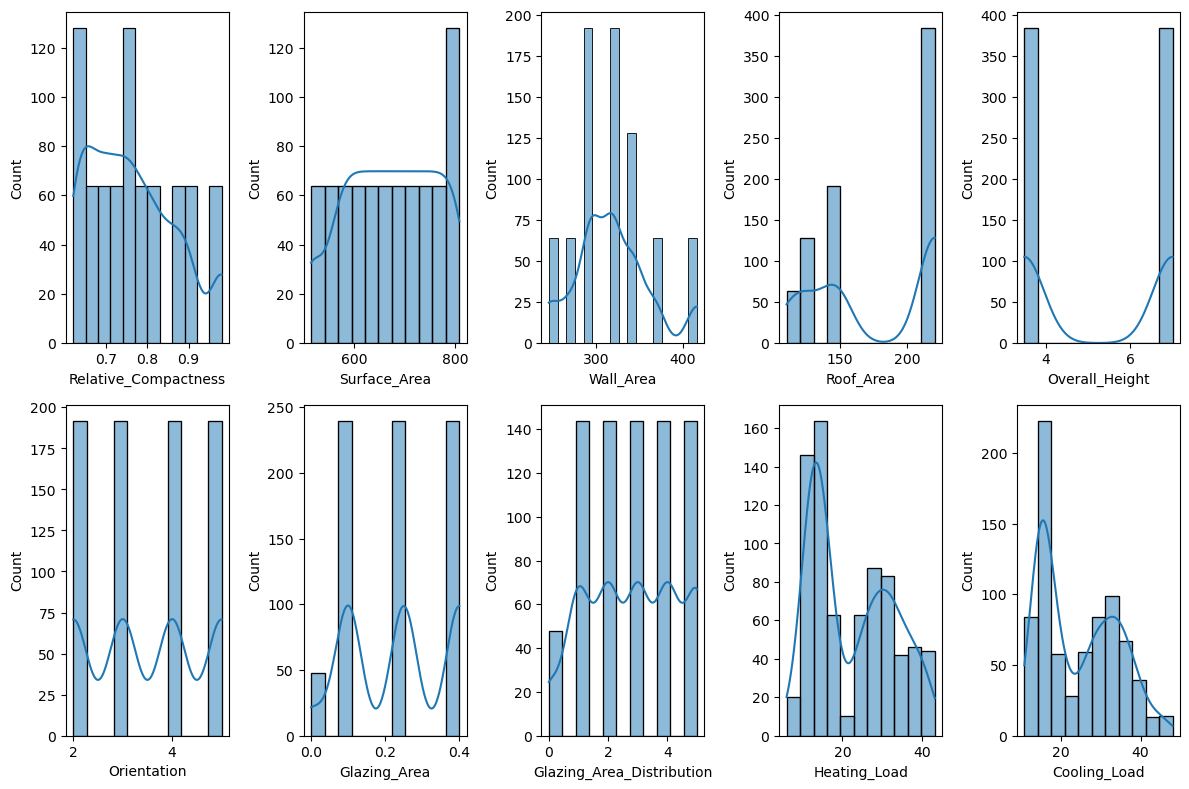

In [6]:
# Visualize the distribution of features
fig, axes = plt.subplots(2, 5, figsize=(12, 8))
axes = axes.flatten()
for i, col in enumerate(df.columns):
    sns.histplot(df[col], kde=True, ax=axes[i])
plt.tight_layout()
plt.show()


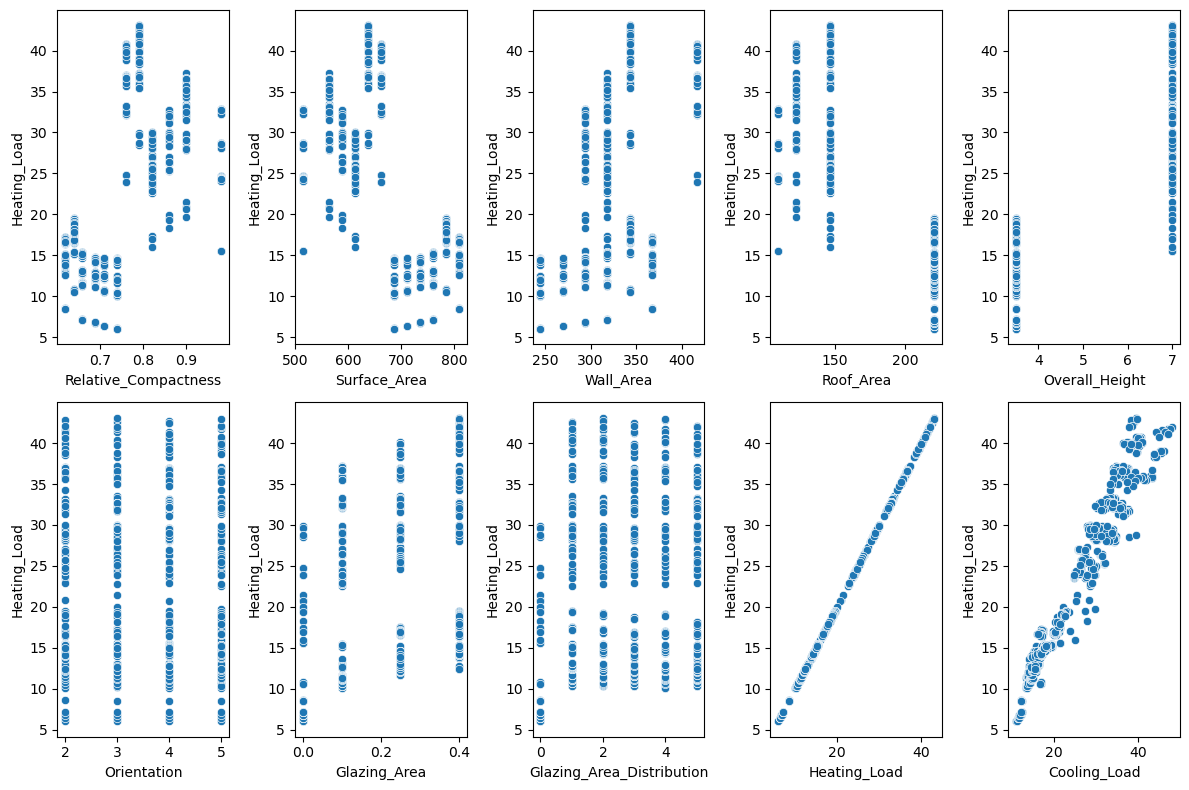

In [7]:
# Visualize relationships with Heating_Load
fig, axes = plt.subplots(2, 5, figsize=(12, 8))
axes = axes.flatten()
for i, col in enumerate(df.columns):
    sns.scatterplot(x=col, y='Heating_Load', data=df, ax=axes[i])
plt.tight_layout()
plt.show()

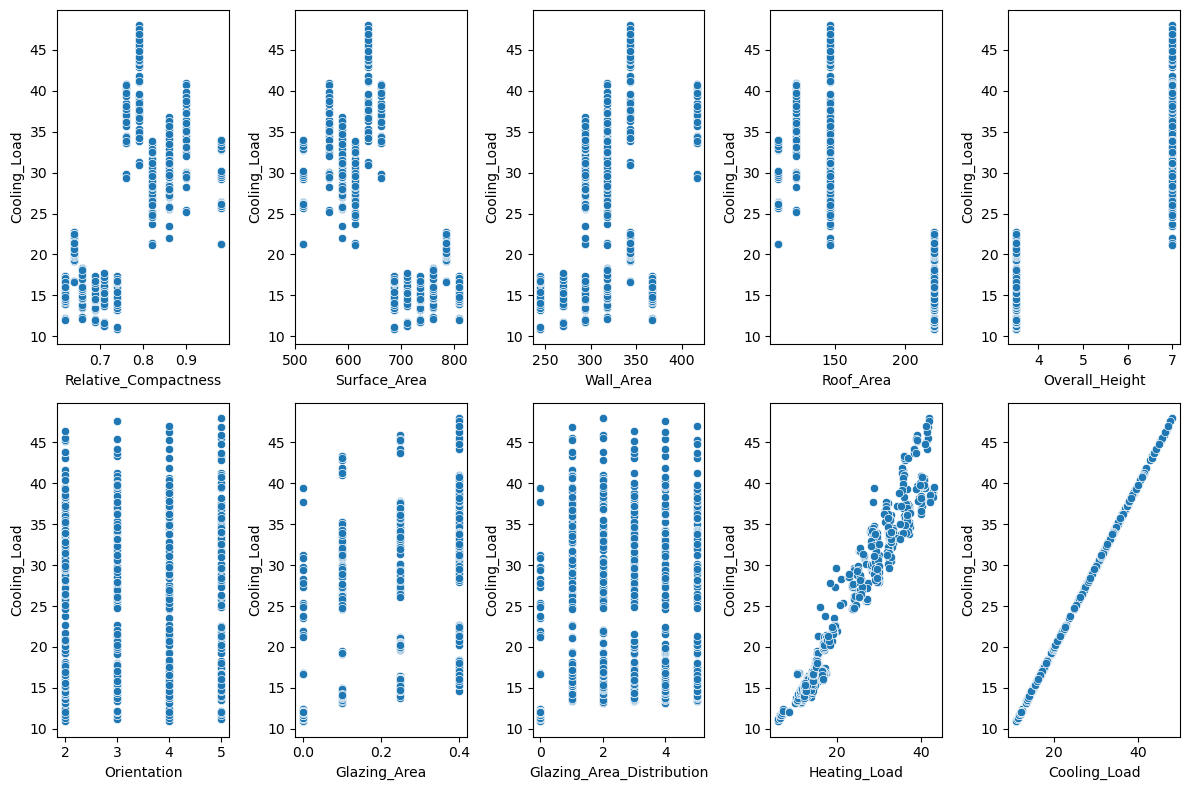

In [8]:
# Visualize relationships with Cooling_Load
fig, axes = plt.subplots(2, 5, figsize=(12, 8))
axes = axes.flatten()
for i, col in enumerate(df.columns):
    sns.scatterplot(x=col, y='Cooling_Load', data=df, ax=axes[i])
plt.tight_layout()
plt.show()

# Modeling

In [9]:
# Prepare features and target variables
X = df.drop(columns=['Heating_Load', 'Cooling_Load'])
y1 = df['Heating_Load']
y2 = df['Cooling_Load']

In [11]:
# Split the dataset into training and test sets
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.3, random_state=42)
X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.3, random_state=42)

In [12]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [13]:
# Hyperparameter tuning for Heating_Load
param_dist = {
    'C': np.logspace(-3, 3, 7),  # Regularization parameter
    'epsilon': np.linspace(0.01, 0.5, 10),  # Epsilon-tube for penalty
    'kernel': ['linear', 'rbf']  # Kernel types
}

svr_heating = SVR()
random_search_heating = RandomizedSearchCV(
    estimator=svr_heating, 
    param_distributions=param_dist,
    scoring='r2', 
    n_iter=20, 
    cv=5, 
    verbose=2, 
    n_jobs=-1, 
    random_state=42
)

# Perform RandomizedSearchCV for Heating_Load
random_search_heating.fit(X_train_scaled, y1_train)
print("Best parameters for Heating Load:", random_search_heating.best_params_)
print("Best R² score for Heating Load:", random_search_heating.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for Heating Load: {'kernel': 'rbf', 'epsilon': 0.17333333333333334, 'C': 1000.0}
Best R² score for Heating Load: 0.9941501964652847


In [14]:
# Hyperparameter tuning for Cooling_Load
svr_cooling = SVR()
random_search_cooling = RandomizedSearchCV(
    estimator=svr_cooling, 
    param_distributions=param_dist,
    scoring='r2', 
    n_iter=20, 
    cv=5, 
    verbose=2, 
    n_jobs=-1, 
    random_state=42
)

# Perform RandomizedSearchCV for Cooling_Load
random_search_cooling.fit(X_train_scaled, y2_train)
print("Best parameters for Cooling Load:", random_search_cooling.best_params_)
print("Best R² score for Cooling Load:", random_search_cooling.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for Cooling Load: {'kernel': 'rbf', 'epsilon': 0.17333333333333334, 'C': 1000.0}
Best R² score for Cooling Load: 0.9656340656108331


In [16]:
# Train SVR for Heating_Load
svm1 = SVR(kernel='rbf',epsilon=0.17333333333333334,C=1000.0)
svm1.fit(X_train_scaled, y1_train)

# Train SVR for Cooling_Load
svm2 = SVR(kernel='rbf',epsilon=0.17333333333333334,C=1000.0)
svm2.fit(X_train_scaled, y2_train)

SVR(C=1000.0, epsilon=0.17333333333333334)

In [17]:
# Predictions and performance metrics for Heating_Load
y1_train_prediction = svm1.predict(X_train_scaled)
y1_test_prediction = svm1.predict(X_test_scaled)

print('Heating Load - Train Prediction Metrics:')
print('MSE:', mean_squared_error(y1_train, y1_train_prediction))
print('R²:', r2_score(y1_train, y1_train_prediction))

print('Heating Load - Test Prediction Metrics:')
print('MSE:', mean_squared_error(y1_test, y1_test_prediction))
print('R²:', r2_score(y1_test, y1_test_prediction))

Heating Load - Train Prediction Metrics:
MSE: 0.06451718927760873
R²: 0.9993648757627722
Heating Load - Test Prediction Metrics:
MSE: 0.31756792053181127
R²: 0.9968680682833041


In [18]:
# Predictions and performance metrics for Cooling_Load
y2_train_prediction = svm2.predict(X_train_scaled)
y2_test_prediction = svm2.predict(X_test_scaled)

print('Cooling Load - Train Prediction Metrics:')
print('MSE:', mean_squared_error(y2_train, y2_train_prediction))
print('R²:', r2_score(y2_train, y2_train_prediction))

print('Cooling Load - Test Prediction Metrics:')
print('MSE:', mean_squared_error(y2_test, y2_test_prediction))
print('R²:', r2_score(y2_test, y2_test_prediction))

Cooling Load - Train Prediction Metrics:
MSE: 0.8369448657753461
R²: 0.9907203567296031
Cooling Load - Test Prediction Metrics:
MSE: 2.126235812869037
R²: 0.9764114665514465
